# Homework Assignment №4 

Обучим маленькую GPT модель (7M):
```python
class GPTConfig:
    context_window = 64
    vocab_size     = 50304
    n_layer        = 4
    n_head         = 8
    n_embd         = 64
```

Подождем 8000 итераций $\left(8000 \cdot 64 \cdot 512 = 262 \text{M токенов}\right)$.

Каждые 250 итераций будем просить модель продолжить промпт `Once upon a time`


In [1]:
from GPT import GPT, GPTConfig, Trainer

config = GPTConfig()
gpt_model = GPT(config=config)

num_params = sum(p.numel() for p in gpt_model.parameters() if p.requires_grad)
print(f"Total Parameters: {num_params / 1e6:.2f}M")

trainer = Trainer()
trainer.train(model=gpt_model, max_steps=8001, verbose=1000)

Total Parameters: 6.64M
======= STEP 1000: =======
Once upon a time processpoloids exist. It index when longer conducting order for $–16.
National daughter-comeos and Be foliage tools are followed
======= STEP 2000: =======
Once upon a time such as his wife depressing the verb of memories and their attention to many curves. After much more loved times answer, all about this statement-
======= STEP 3000: =======
Once upon a time there are expected to follow some more interesting A index containing warp shelf suffering and possessed both accurately and is out of the idea that multiple types of
======= STEP 4000: =======
Once upon a time. He points for the answer said she should conclude that it isn't a dedicated to research and write a 2011 Parliament.orges will call
======= STEP 5000: =======
Once upon a time covered sugar bag should be snatched by boiling again from a more common.
Look for itsirding gruses, travel outdoors, grail
======= STEP 6000: =======
Once upon a timeeb Moderate a

Видим, что сначала модель придумывает слова и пишет очень несвязно, но со временем грамматика становится лучше и лучше.

Для получения связной речи необходимо увеличить размер модели и число итераций.

### Визуализируем логи обучения

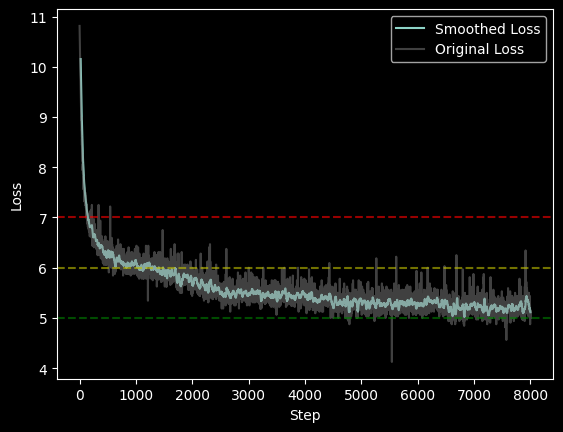

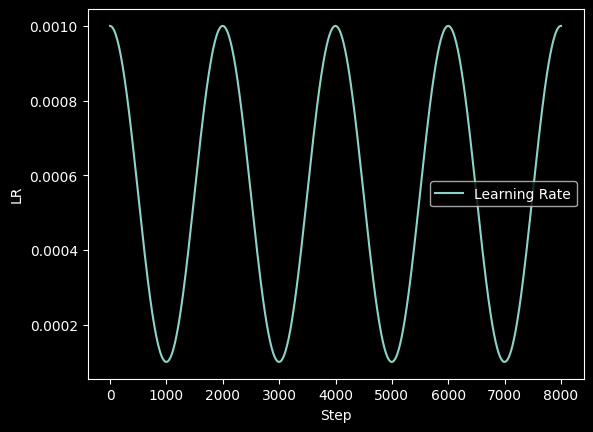

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# DISPLAY LOSS
data = pd.read_csv("training_logs.csv")
window_size = 20
smoothed_loss = data["Loss"].rolling(window=window_size).mean()

plt.plot(data["Step"], smoothed_loss, label="Smoothed Loss")
plt.plot(data["Step"], data["Loss"], alpha=0.5, label="Original Loss", color="gray")

plt.axhline(y=7, color='r', linestyle='--', alpha=0.6)
plt.axhline(y=6, color='y', linestyle='--', alpha=0.6)
plt.axhline(y=5, color='g', linestyle='--', alpha=0.6)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

# DISPLAY LEARNING RATE
plt.plot(data["Step"], data["LR"], label="Learning Rate")
plt.xlabel("Step")
plt.ylabel("LR")
plt.legend()
plt.show()

Параметров недостаточно, чтобы выучить сложные зависимости, поэтому `loss` начинает осциллировать в окрестности 5.

### Посмотрим на первый слой внимания

Once upon a time higher investment in consumer radiant soil


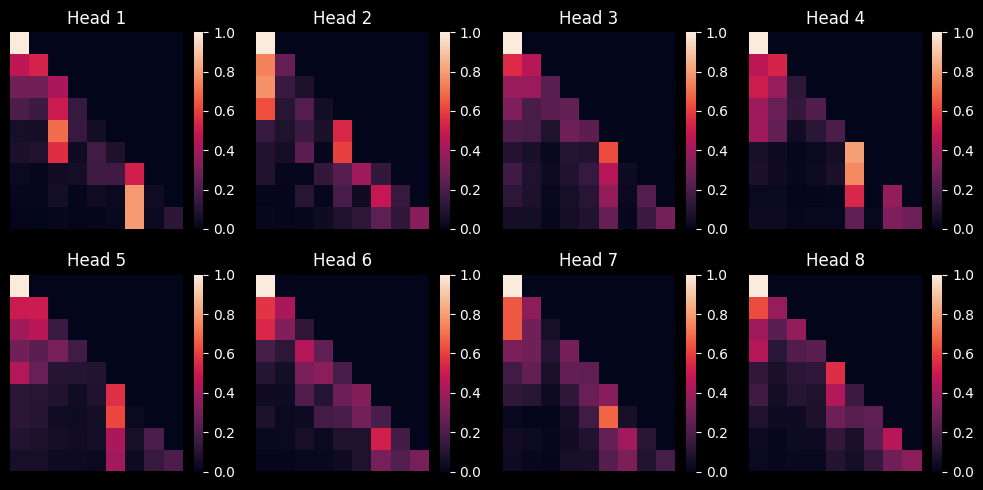

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import functional as F

# Model is called to compute attention weights
trainer._generate_text(gpt_model, max_length=10)

attention_weights = gpt_model.transformer.h[0].attn.attn_weights
attention_weights = attention_weights[0].cpu().detach().numpy()
fig, axes = plt.subplots(2, gpt_model.config.n_head // 2, figsize=(10, 5))
for i in range(gpt_model.config.n_head):
    row, column = i >> 2, i % 4
    sns.heatmap(attention_weights[i], ax=axes[row][column])
    axes[row][column].set_title(f'Head {i+1}')
    axes[row][column].set_axis_off()

plt.tight_layout()
plt.show()

## Выводы:

- При генерации последнего токена модель почти не "смотрит" на сгенерированные в самом начале
- Вертикальные полоски (например, в 4ой голове) означают, что некоторые токены важны для нескольких последующий.
- Больше всего внимания уделяется последнему токену